In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Rk4 algorithm
def rk4_(t, u, v, dt, f, g, omega, func):
    k1 = dt * f(u, v)
    l1 = dt * g(t, u, v, omega, func)

    k2 = dt * f(u + 0.5 * k1, v + 0.5 * l1)
    l2 = dt * g(t + 0.5 * dt, u + 0.5 * k1, v + 0.5 * l1, omega, func)

    k3 = dt * f(u + 0.5 * k2, v + 0.5 * l2)
    l3 = dt * g(t + 0.5 * dt, u + 0.5 * k2, v + 0.5 * l2, omega, func)

    k4 = dt * f(u + k3, v + l3)
    l4 = dt * g(t + dt, u + k3, v + l3, omega, func)

    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
    v_next = v + (l1 + 2*l2 + 2*l3 + l4) / 6

    return u_next, v_next

def rk4(n, u0, v0, dt, fu, fv, omega, func):

    t = [0]
    u = [u0]
    v = [v0]

    for i in range(n):

        u_, v_ = rk4_(t[-1], u[-1], v[-1], dt, fu, fv, omega, func)

        t.append(t[-1]+dt)
        u.append(u_)
        v.append(v_)

    return t, u, v

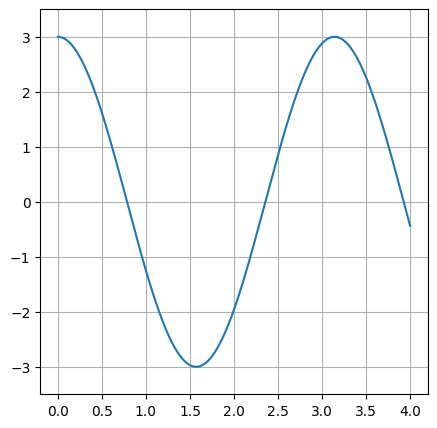

In [3]:
def func(t, u, v):
    return 0
    return -0.5*np.sin(t)

def fu(u, v):

    return v

def fv(t, u, v, omega, func):

    f = func(t, u, v)

    return f - omega**2 * u

u0 = 3
v0 = 0
omega = 2

dt = 1e-2

t, u, v = rk4(400, u0, v0, dt, fu, fv, omega, func)

plt.figure(figsize=(5,5))
plt.ylim(-3.5,3.5)
plt.plot(t, u)
plt.grid()
plt.show()

In [4]:
X = []
Y = []

for i in range(3,len(u)-3):
    X.append([t[i], u[i-1], u[i-2], u[i-3], v[i-1], v[i-2], v[i-3]])
    Y.append([u[i], v[i]])

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [5]:
class FibGNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear map from 7 inputs (last 7 numbers) to 5 outputs (next 5 numbers)
        self.fc1 = nn.Linear(7, 7, bias=False)
        self.fc2 = nn.Linear(7, 5, bias=False)
        self.fc3 = nn.Linear(5, 2, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, last_two):
        # last_two: tensor [batch, 5] with [F_n, F_{n+1}, F_{n+2}, V_n, V_{n+1}]
        x = self.fc1(last_two)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        return self.fc3(x)

In [6]:
class FibGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 64, bias=True)
        self.fc2 = nn.Linear(64, 32, bias=True)
        self.fc3 = nn.Linear(32, 16, bias=True)
        self.fc4 = nn.Linear(16, 2, bias=True)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [7]:
class FibGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        # Predizer apenas o incremento, não o valor absoluto
        x1 = F.relu(self.fc1(x))
        x2 = F.relu(self.fc2(x1)) + x1  # Residual connection
        delta = self.fc3(x2)
        
        # Adicionar incremento aos valores anteriores
        u_prev = x[:, 1]  # u[i-1]
        v_prev = x[:, 4]  # v[i-1]
        
        return torch.stack([u_prev + delta[:, 0], v_prev + delta[:, 1]], dim=1)

In [8]:
model = FibGNN()
criterion = nn.MSELoss()

In [17]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
for epoch in range(20000):
    pred = model(X).squeeze()
    loss = criterion(pred, Y)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


#print("Learned weight matrix:", model.fc.weight.data)

Epoch 0, Loss: 1.4403271961782593e-06
Epoch 1000, Loss: 6.22675486283697e-07
Epoch 2000, Loss: 5.399772362579824e-07
Epoch 3000, Loss: 4.667197117669275e-07
Epoch 4000, Loss: 4.359964123068494e-07
Epoch 5000, Loss: 1.2250990266693407e-06
Epoch 6000, Loss: 3.214327932710148e-07
Epoch 7000, Loss: 3.0622138069702487e-07
Epoch 8000, Loss: 3.112675699412648e-07
Epoch 9000, Loss: 2.5339173248539737e-07
Epoch 10000, Loss: 3.738271061592968e-07
Epoch 11000, Loss: 2.9461915573847364e-07
Epoch 12000, Loss: 2.5900951072799216e-07
Epoch 13000, Loss: 2.3492866318974848e-07
Epoch 14000, Loss: 2.4026178380154306e-07
Epoch 15000, Loss: 1.6508390388025873e-07


KeyboardInterrupt: 

In [19]:
print(pred[0,1])

tensor(-0.3597, grad_fn=<SelectBackward0>)


In [20]:
# Predict series starting from initial conditions
u_preds = [u[0], u[1], u[2]]  # Ordem temporal correta
v_preds = [v[0], v[1], v[2]]

X_preds = []
Y_preds = []

# Começar do tempo inicial com incremento correto
current_time = t[3]  # Próximo tempo após os 3 valores iniciais

N = 390  # Número de predições a serem feitas

for i in range(N):  # Predizer mais pontos para visualizar melhor
    # Criar input com últimos 3 valores em ordem temporal correta
    input_ = [current_time, u_preds[-1], u_preds[-2], u_preds[-3], 
              v_preds[-1], v_preds[-2], v_preds[-3]]
    
    input_tensor = torch.tensor(input_, dtype=torch.float32).unsqueeze(0)
    pred = model(input_tensor)
    
    # Adicionar no final (ordem temporal correta)
    u_preds.append(pred[0][0].item())
    v_preds.append(pred[0][1].item())
    
    X_preds.append(input_)
    Y_preds.append([u_preds[-1], v_preds[-1]])
    
    current_time += dt  # Incremento consistente com o treinamento

X_preds = torch.tensor(X_preds, dtype=torch.float32)
Y_preds = torch.tensor(Y_preds, dtype=torch.float32)
u_preds = torch.tensor(u_preds, dtype=torch.float32)
v_preds = torch.tensor(v_preds, dtype=torch.float32)

In [21]:
print(X_preds.shape)
print(Y_preds.shape)
print(u_preds[-4])
print(u_preds.shape)

torch.Size([390, 7])
torch.Size([390, 2])
tensor(0.0606)
torch.Size([393])


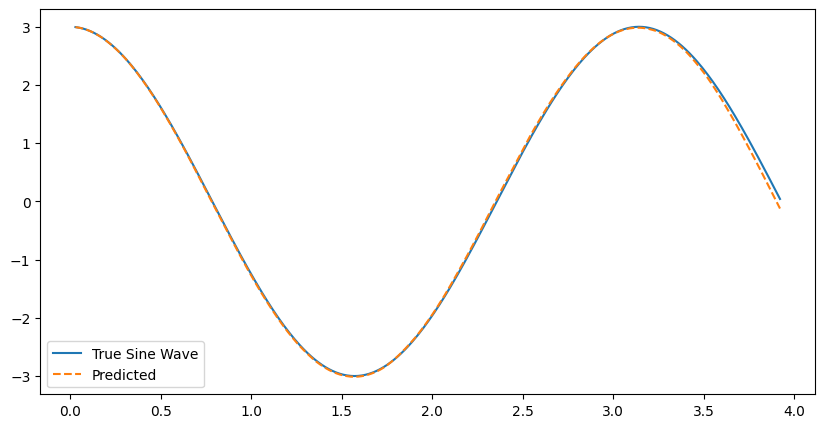

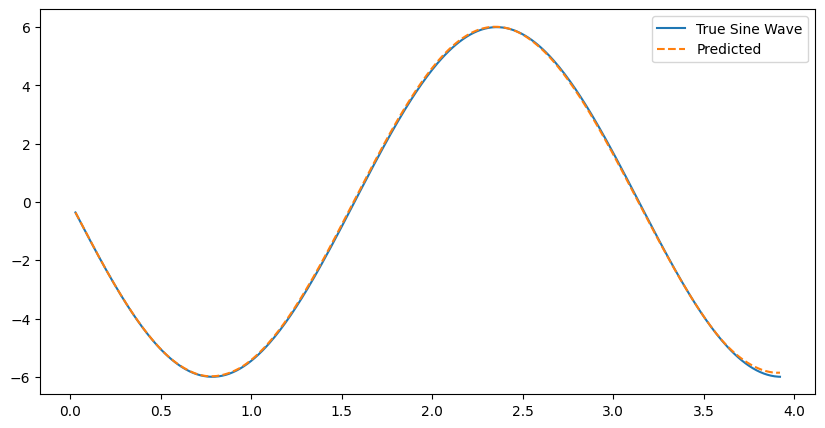

In [22]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(X_preds[:N,0].numpy(), Y[:N,0].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,0].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

# Plot results
plt.figure(figsize=(10,5))
plt.plot(X_preds[:N,0].numpy(), Y[:N,1].numpy(), label='True Sine Wave')
plt.plot(X_preds[:,0].numpy(), Y_preds[:,1].numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()

In [23]:
print(Y.shape)

torch.Size([395, 2])


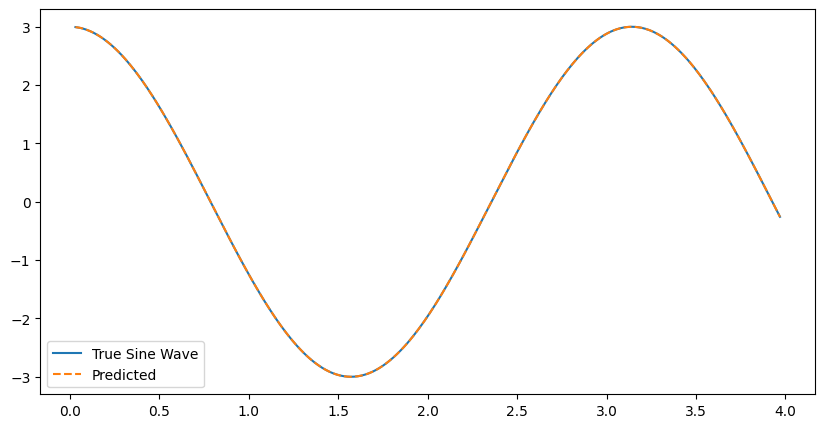

In [24]:

# Predict series starting from x[5]

pred = model(X)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(X[:,0], Y[:,0].numpy(), label='True Sine Wave')
plt.plot(X[:,0], pred[:,0].detach().numpy(), label='Predicted', linestyle='--')
plt.legend()
plt.show()